# Inspecting bias due to systematic modeling

In this notebook toy datasets are generated from the Asimov dataset accounting for statistical and systematic uncertainties in the model.  Each toy dataset is fit as in the nominal analysis and the estimated model parameters are compared to their input values.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize, basinhopping
from scipy.stats import norm, lognorm
from tqdm.notebook import tqdm

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 58195,
  "iopub_port": 33483,
  "stdin_port": 49661,
  "control_port": 55831,
  "hb_port": 53957,
  "ip": "127.0.0.1",
  "key": "16035760-e2411aad0d09b4bc98a10255",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-deea6ad1-abba-412b-9388-9b77f63384fb.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
do_gof_toys = False
input_dir  = f'local_data/templates/test_08242020_jetavg/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'gjets', 'diboson', 'fakes'] 
selections = [
    'ee',  'mumu',  
    'emu', 
    'mutau',  'etau', 
    'mujet',  'ejet'
   ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, 
                      param_file  = 'data/model_parameters_alt.csv',
                      process_cut = 0.05
                     )
parameters = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()

In [3]:
# initialize category veto list
fit_data.veto_list = [
    # baseline
    #'ee_cat_gt2_eq1_b', 'ee_cat_gt2_gt2_b', 
    #'mumu_cat_gt2_eq1_b', 'mumu_cat_gt2_gt2_b', 
    #'emu_cat_gt2_eq1_a', 'emu_cat_gt2_gt2_a', 
    #'etau_cat_eq2_eq1', 'etau_cat_gt3_eq1', 
    #'etau_cat_eq2_gt2', 'etau_cat_gt3_gt2', 
    #'mutau_cat_eq2_eq1', 'mutau_cat_gt3_eq1', 
    #'mutau_cat_eq2_gt2', 'mutau_cat_gt3_gt2', 
    #'ejet_cat_gt4_eq1', 'ejet_cat_gt4_gt2',
    #'mujet_cat_gt4_eq1', 'mujet_cat_gt4_gt2', 
    'ejet_cat_eq3_gt2', 'mujet_cat_eq3_gt2',
    
    # e/mu DY CR
    'ee_cat_gt2_eq0',  'mumu_cat_gt2_eq0', 
    
    # e+mu additional ttbar
    #'emu_cat_gt2_eq0', 'emu_cat_eq1_eq0_a', 'emu_cat_eq1_eq1_a', 
    
    # e+mu WW
    #'emu_cat_eq0_eq0_a', 
    
    # e/mu+tau additional CR
    #'mutau_cat_eq0_eq0', 'mutau_cat_eq1_eq0', 
    #'mutau_cat_gt2_eq0', 'mutau_cat_eq1_eq1', 
    #'etau_cat_eq0_eq0', 'etau_cat_eq1_eq0', 
    #'etau_cat_gt2_eq0', 'etau_cat_eq1_eq1', 
]

In [4]:
# generate scan points
beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                [(0.104, 0.118), (0.104, 0.118), (0.104, 0.118)], 
                                [8, 8, 8]
                                )
scan_vals = np.array(beta_scan_vals.get_scan_vals()[0])
beta_h = np.transpose([1 - np.sum(scan_vals, axis=1)])
scan_vals = np.hstack((scan_vals, beta_h, np.outer(np.ones(scan_vals.shape[0]), params_pre[4:])))

In [5]:
# initialize objective and its jacobian
fobj = partial(fit_data.objective,
               data = None,
               do_bb_lite = True,
               no_shape = False,
               randomize_templates = True,
               lu_test = 2
              )

fobj_jac = partial(fit_data.objective_jacobian,
                   data = None,
                   do_bb_lite = True,
                   no_shape = False,
                   randomize_templates = True,
                   lu_test = 2
                  )


In [6]:
# carry out the scan #

# minimizer options
min_options = dict(
                   #eps=1e-10,
                   gtol=1e-4, 
                   disp=True
                  )

results = []
sv_accept = []
cost = dict(initial = [], fit = [])
gof = dict(chi2 = [], cb = [])
mask = fit_data._pmask
pinit = params_pre[mask]
for ix, sv in tqdm(enumerate(scan_vals), total=scan_vals.shape[0]):
    
    if do_gof_toys:
        sv[:4] = params_pre[:4]
    
    # randomize n.p.
    np_random = params_pre.copy()
    
    norm_mask = (parameters.pdf == 'lognorm').values
    norm_rvs = np.array([lognorm.rvs(s=d.err_init, scale=d.val_init) for n, d in parameters.query('pdf == "lognorm"').iterrows()])
    np_random[norm_mask] = norm_rvs
    
    shape_mask = (parameters.pdf == 'gaussian').values
    shape_rvs = np_random[shape_mask] + parameters.loc[shape_mask].err_init*np.random.randn(shape_mask.sum())
    np_random[shape_mask] = shape_rvs
    #print(np_random)
    
    fit_data._pval_init = np_random
    
    # generate data from scan values w/ statistical variation
    sample = dict()
    for category in fit_data._categories:
        val, var = fit_data.mixture_model(sv, category)
        sample[category] = [np.random.poisson(val), val]
        #sample[category] = [val, val]
    
    # randomize templates
    fit_data
    fobj.keywords['data'] = sample
    fobj_jac.keywords['data'] = sample

    # carry out minimization
    result = minimize(fobj, pinit, 
                      method  = 'BFGS', 
                      options = min_options,
                      jac     = fobj_jac,
                      #args    = (sample)
                     )
    
    if result.fun > 300:
        continue
    
    # calculate Pearson chi2 and Cousins-Baker gof
    chi2 = 0
    cb_gof = 0
    for category, obs_val in sample.items():
        params = params_pre.copy()
        params[mask] = result.x
        exp_val, exp_var = fit_data.mixture_model(params, category)
        exp_val *= fit_data._bb_np[category]
        chi2 += np.sum((exp_val - obs_val[0])**2/exp_val)
        cb_gof += 2*np.sum(exp_val - obs_val[0]*(1 - np.log(obs_val[0]/exp_val)))
        
    print(f'scan {ix}', result.success, fit_data.objective(pinit), fit_data.objective(sv[mask]), result.fun)
    print()
    #print(' jacobian: ', result.jac)
    #print(' init vals: ', pinit)
    #print(' nps: ', np_random)
    print(f' scan vals: {sv[:4]}')
    print(f' fit vals: {result.x[:4]}', end='\n\n')
    print(f'chi2 = {chi2}, cousins-baker = {cb_gof}')
    print(' % diff vals:', 100*(result.x[:4] - sv[:4])/sv[:4], end='\n\n')
    
    results.append(result.x)
    cost['initial'].append(fit_data.objective(pinit))
    cost['fit'].append(result.fun)
    sv_accept.append(sv[mask])
    gof['chi2'].append(chi2)
    gof['cb'].append(cb_gof)
    

         Current function value: 193.229065
         Iterations: 67
         Function evaluations: 156
         Gradient evaluations: 144
scan 0 False 1616.3807302519149 1243.3559430987902 193.22906456935576

 scan vals: [0.104 0.104 0.104 0.688]
 fit vals: [0.1041 0.1038 0.1062 0.686 ]

chi2 = 296.1841954551059, cousins-baker = 296.836472325411
 % diff vals: [ 0.053  -0.1626  2.0756 -0.2972]

         Current function value: 210.845471
         Iterations: 64
         Function evaluations: 117
         Gradient evaluations: 106
scan 1 False 1612.8198380702074 1194.9248996860215 210.84547109988108

 scan vals: [0.104 0.104 0.106 0.686]
 fit vals: [0.1029 0.1039 0.1076 0.6857]

chi2 = 299.948412284512, cousins-baker = 300.3039563189949
 % diff vals: [-1.0951 -0.1356  1.5294 -0.0497]

         Current function value: 219.396170
         Iterations: 66
         Function evaluations: 181
         Gradient evaluations: 169
scan 2 False 1622.63740548239 1180.9106221955844 219.39617016788625


In [7]:
#calculate biases
results = np.array(results)
sv_accept = np.array(sv_accept)
cost_fit = np.array(cost['fit'])
cost_initial = np.array(cost['initial'])
gof_chi2 = np.array(gof['chi2'])
gof_cb = np.array(gof['cb'])


diff = (results - sv_accept)
diff[:,:4] /= 0.01*pinit[:4]
#diff[:,:4] /= 0.01*sv_accept[:,:4]
diff[:,4:diff.shape[1]] /= parameters['err_init'][4:diff.shape[1]].values

#diff = np.array([d for d in diff if np.all((d > -10) & (d < 10))])

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


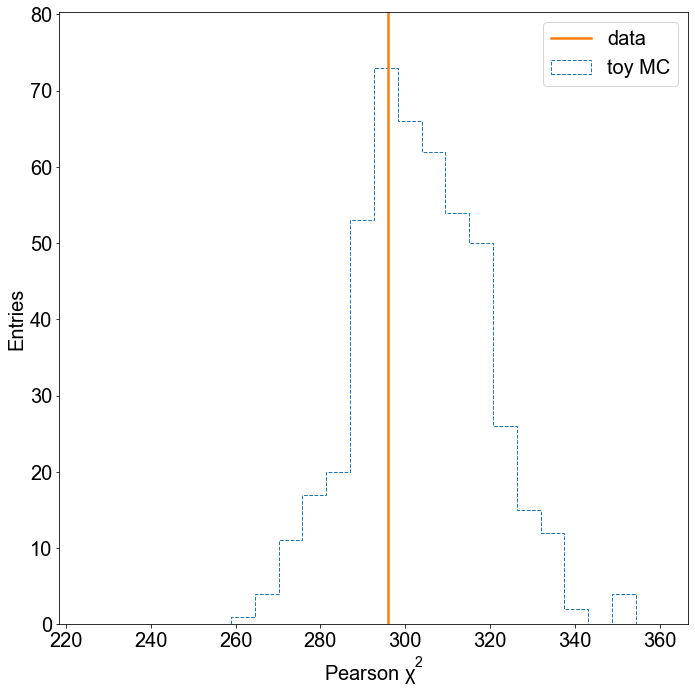

In [8]:
# plot the cost
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')


cost_mean, cost_err = cost_fit.mean(), cost_fit.std()
binning = np.linspace(np.max([0, gof_chi2.mean() - 5*cost_err]), 360, 25)
#ax.hist(cost_initial, bins=binning, histtype='stepfilled')
#ax.hist(cost_fit, bins=binning, histtype='stepfilled')
h, _, _ = ax.hist(gof_chi2, bins=binning, linestyle='--', histtype='step', label='toy MC')
#ax.hist(gof_cb, bins=binning, linestyle='--', histtype='step')
ax.plot([296, 296], [0, 100], label='data')
ax.set_xlabel(r'Pearson $\chi^{2}$')
ax.set_ylabel('Entries')
ax.set_ylim(0, 1.1*h.max())
ax.legend()

plt.tight_layout()
plt.savefig('plots/gof_toys.png')
plt.show()

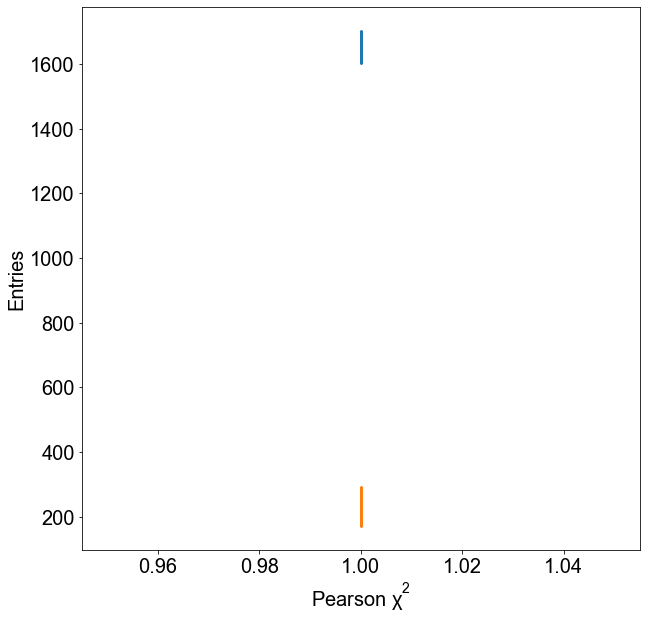

In [9]:
# plot the cost
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

ax.plot(np.ones([cost_initial.size, 2]), np.vstack([cost_initial, cost_fit]).T)
ax.set_xlabel(r'Pearson $\chi^{2}$')
ax.set_ylabel('Entries')

plt.show()

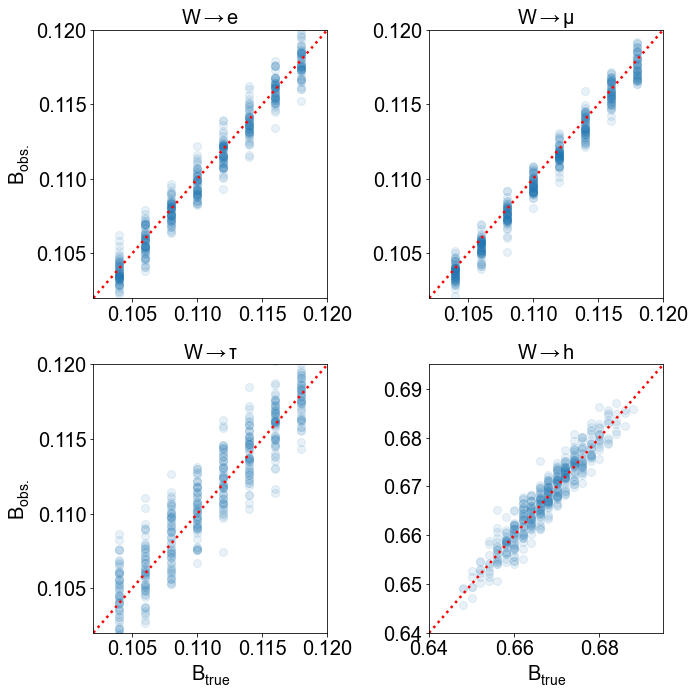

In [10]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=False, sharey=False)

beta_val = sv_accept[:,:4]
beta_obs = results[:,:4]

ax = axes[0][0]
ax.plot(beta_val[:,0], beta_obs[:,0], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
ax.plot(beta_val[:,1], beta_obs[:,1], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
ax.plot(beta_val[:,2], beta_obs[:,2], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
ax.plot(beta_val[:,3], beta_obs[:,3], 'C0o', alpha=0.1)
ax.plot([0.64, 0.72], [0.64, 0.72], 'r:')
ax.set_xlim(0.64, 0.695)
ax.set_ylim(0.64, 0.695)
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow h$', size=20)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_scan.pdf')
plt.show()

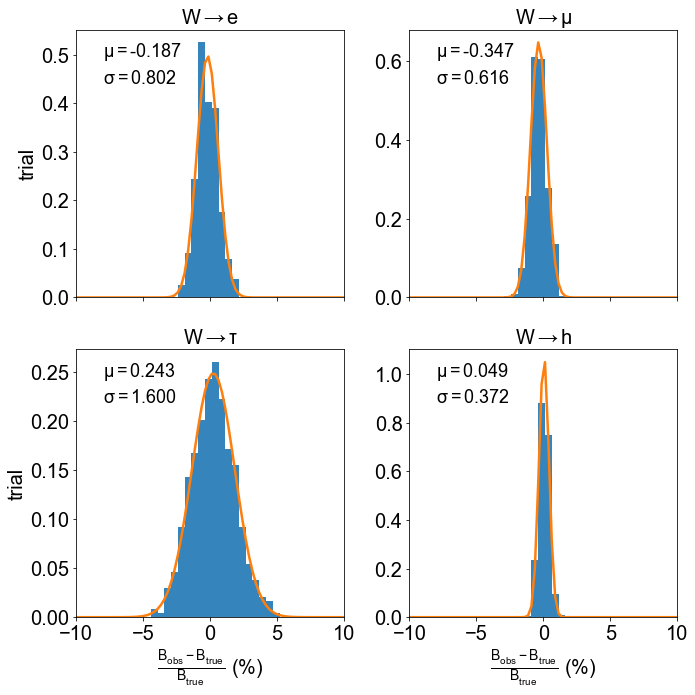

In [11]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=True, sharey=False)
bins = np.linspace(-10, 10, 80)

ax = axes[0][0]
dbeta = 100*(beta_obs[:,0] - beta_val[:,0])/beta_val[:,0]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_ylabel('trial')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
dbeta = 100*(beta_obs[:,1] - beta_val[:,1])/beta_val[:,1]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
dbeta = 100*(beta_obs[:,2] - beta_val[:,2])/beta_val[:,2]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_ylabel('trial')
ax.set_xlabel(r'$\frac{B_{obs} - B_{true}}{B_{true}}$ (%)')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
dbeta = 100*(beta_obs[:,3] - beta_val[:,3])/beta_val[:,3]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_xlabel(r'$\frac{B_{obs} - B_{true}}{B_{true}}$ (%)')
ax.set_title(r'$W\rightarrow h$', size=20)

ax.set_xlim(-10, 10)
ax.set_ylim(0., None)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_bias.pdf')
plt.show()

In [ ]:
#plotting the results (compare to asimov dataset)
fig, axes = plt.subplots(2, 1, figsize=(30, 15), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[3,1]})

df_pulls = pd.read_csv('data/model_parameters_asimov.csv').query('active == True')
df_pulls.loc[:3, 'ratio'] *= 100
df_pulls = df_pulls.set_index('name')
pull_post = (df_pulls['val_fit'] - df_pulls['val_init'])/df_pulls['err_init']

nparams = params[mask].shape[0]
xticks = np.outer(np.arange(nparams), np.ones(diff.shape[0])).T
ax = axes[0]
ax.plot(xticks+1,  diff, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff.mean(axis=0), diff.std(axis=0), fmt='C0o', capsize=10, elinewidth=5, label='scan')
ax.errorbar(xticks[0]+1,  pull_post.values, df_pulls['ratio'], fmt='C1o', capsize=10, elinewidth=5, label='Hessian')
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)
#ax.boxplot(diff)

# extra dressing
ax.set_ylabel(r'$\delta\theta_{post}/\delta\theta_{pre}$')
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')
ax.legend(fontsize=20)

ax = axes[1]
err_ratio = diff.std(axis=0)/df_pulls['ratio'].values
ax.plot(xticks[0]+1,  err_ratio, 'ko', alpha=0.9, markersize=10)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params[mask].label, size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.set_xlim(4.5, nparams+0.5)

ax.set_ylabel(r'toys/$\mathcal{H}_{NLL}$')
ax.set_ylim(0.25, 1.75)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/new_pulls.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

xticks = np.outer(np.arange(4), np.ones(diff.shape[0])).T
ax.plot(xticks+1,  diff[:,:4], 'ko', alpha=0.1, markersize=4)
#ax.boxplot(diff)
ax.errorbar(xticks[0,:4]+1,  diff[:,:4].mean(axis=0), diff[:,:4].std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

print(diff[:,:4].std(axis=0))

# extra dressing
ax.set_xticks(xticks[0,:4]+1)
ax.set_xticklabels(params.label[:4], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\delta\theta/\theta$ (%)')
ax.set_xlim(0.5, nparams+0.5)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor='white')

ip_low, ip_high = 4, 7 + fit_data._nnorm
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/norm_params.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 18, 46
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_reco_params.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 47, 65
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_btag_params.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 65, 84
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_jes_params.pdf')
plt.show()